## Search for more habitable planets

PHE identifies a handful of exoplanets as habitable ones out of more than 4000 exoplanets. 
Given numbers of inhabitable exoplanets are enormouse, and still a little chance to make the mistake on this identification,
we target to verify this identification, and try to find out more habitable exoplanet from inhabitable set.

Our approach is:
1. Pick up all inhabitable ones, all of given features judging habitability have values.
2. Using clustering algorithms to try to find the inhabitable ones closed to habitable ones.
3. Using cosine similiarity to compare habitable ones with inhabitable one, and pick up the closed one as candidates.
4. Using Chatgpt to verify the closed one, and select the final candidates for manual verification.

It is possible for some exoplanets not to have the critical features such as mass or radius. For this, the supervised
learning will be taken such as logistic regression to predict the critical features, then take the above process.
It may increase the chances to look for more habitable exoplanets.

In [52]:
# Load the necessary libraries
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn', to avoid warnings

### 1. Data Preparation

##### 1.1 Identify target exoplanets

In [53]:
# Access NASA Exoplanets Archive Data by the following:
# https://exoplanetarchive.ipac.caltech.edu/docs/TAP/usingTAP.html
import requests

def get_json_data(url):
    # Send a GET request to the specified URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Convert the JSON response to a pandas dataset
        json_data = response.json()
        dataset = pd.DataFrame(json_data)
        return dataset
    else:
        # Handle the request error
        print(f"Request failed with status code: {response.status_code}")
        return None


In [54]:

def get_all_confirmed_exoplanets():
    # Query the NASA Exoplanet Archive for all confirmed exoplanets
    #exoplanets = NasaExoplanetArchive.query_criteria(table="exoplanets", select="*")
    url = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=JSON'  # Replace with the actual URL
    exoplanets = get_json_data(url)
    return exoplanets

In [55]:
# Example usage
import os

if os.path.exists("../assets/data/exoplanets.csv"):
    exoplanets = pd.read_csv("../assets/data/exoplanets.csv",low_memory=False)
else:
    exoplanets = get_all_confirmed_exoplanets()
    if exoplanets is not None:
        # Process and analyze the dataset as needed
        # ...
        print(exoplanets.head())
        exoplanets.to_csv("./assets/data/exoplanets.csv", index=False)

In [56]:
# count list of confirmation status without being questioned.
exoplanets.pl_name[exoplanets.pl_controv_flag==0].count()

34671

In [57]:
exoplanets[exoplanets.pl_name.str.find('11 Com b')==0]['pl_rade']

1513    NaN
19475   NaN
Name: pl_rade, dtype: float64

##### 1.2 Load habitable zone’s data

In [58]:

hz=pd.read_csv('../assets/data/table.csv')

In [59]:
hz.head()

,PLANET,MASS,RADIUS,PERIOD,ECC,OMEGA,THZC,THZO,TEQA,TEQB,TEQC,TEQD,OHZIN,CHZIN,CHZOUT,OHZOUT
0,11 Com b,19.400,,326.0,0.231,94.8,0.0,0.0,1209.5,1017.1,956.0,803.9,10.481,13.276,24.285,25.615
1,11 UMi b,14.740,,516.2,0.080,90.0,0.0,0.0,1111.3,934.5,1025.6,862.5,12.783,16.192,30.355,32.018
2,14 And b,4.800,,185.8,0.000,0.0,0.0,0.0,1003.1,843.5,1003.1,843.5,6.013,7.617,13.890,14.651
3,16 Cyg B b,1.780,,798.5,0.680,90.0,21.2,29.2,480.8,404.3,209.9,176.5,0.842,1.066,1.881,1.984
4,17 Sco b,4.320,,578.4,0.060,57.0,0.0,0.0,1038.4,873.2,977.9,822.3,10.825,13.712,25.776,27.188


##### 1.3  Load open exoplanet catlogue’s data

In [60]:

oec=pd.read_csv('../assets/data/open_exoplanet_catalogue.csv')

In [61]:
oec[oec.name.str.find('11 Com b')==0]['radius']

1011   NaN
Name: radius, dtype: float64

Conclusion: Lack of raidus data in HZ still exists in both NASA and oec

##### 1.4 Remove the rows without MASS or Radius

In [62]:

# write a code to remove the following blank between ',' in all columns of hz, then
# count the number of rows by each column which contains nothing
def count_null(df):
    for column in df.columns:
        #print(column)
        if df[column].dtype=='object':
            df[column]=df[column].str.strip()
            #df[df[column]==''][column]=np.nan
            print("%s: %d" %(column, df[df[column]==''][column].count()))
        else:
            print("%s: %d" %(column, df[df[column].isnull()][column].count()))
    return df

hz_nona=count_null(hz)

PLANET: 0
MASS: 2876
RADIUS: 784
PERIOD: 0
ECC: 0
OMEGA: 0
THZC: 0
THZO: 0
TEQA: 0
TEQB: 0
TEQC: 0
TEQD: 0
OHZIN: 0
CHZIN: 0
CHZOUT: 0
OHZOUT: 0


In [63]:
# Remove the rows whose mass or radius does not exist since either of them is necessary for calculating the habitable zone
hz_nona=hz_nona[(hz_nona['MASS']!='') & (hz_nona['RADIUS']!='')]

# Remove the rows whose mass or radius is not a number
hz_nona=hz_nona[(hz_nona['MASS']!='nan') & (hz_nona['RADIUS']!='nan')]

# Find out the rows whose either mass or radius is not a number


# change dtypes of mass and radius to float
hz_nona['MASS']=hz_nona['MASS'].astype(float)
hz_nona['RADIUS']=hz_nona['RADIUS'].astype(float)

In [64]:
hz_nona.count()

PLANET    1003
MASS      1003
RADIUS    1003
PERIOD    1003
ECC       1003
OMEGA     1003
THZC      1003
THZO      1003
TEQA      1003
TEQB      1003
TEQC      1003
TEQD      1003
OHZIN     1003
CHZIN     1003
CHZOUT    1003
OHZOUT    1003
dtype: int64

In [65]:
# remove the ' ' in hz.PLANET
hz.PLANET=hz.PLANET.apply(lambda x: str(x).strip())

In [66]:
# 4. Read the candidate of habitable planets
phe=pd.read_csv('../assets/data/PHE.csv')

In [67]:
# remove the '\xa0(N)' in phe.Planet
phe.Planet=phe.Planet.apply(lambda x: str(x).strip().replace('\xa0(N)',''))

In [68]:
phe.head()

,Planet,Type,Mass,Radius,Flux,Tsurf,Period,Distance,ESI,cat
0,Teegarden's Star b,M-Warm Terran,≥ 1.05,~ 1.02,1.15,~ 298,4.9,12.0,0.95,Conservative
1,TOI-700 d,M-Warm Terran,~ 1.57,1.14,0.87,~ 278,37.4,101.0,0.93,Conservative
2,Kepler-1649 c,M-Warm Terran,~ 1.20,1.06,1.23,~ 303,19.5,301.0,0.92,Conservative
3,TRAPPIST-1 d,M-Warm Subterran,0.39,0.78,1.12,~ 296,4.0,41.0,0.91,Conservative
4,LP 890-9 c,M-Warm Terran,—,1.37,0.91,~ 281,8.5,106.0,0.89,Conservative


In [69]:
# Combine hz with phe by planet name,also only keep cat as phe's column 
ex_columns=['OMEGA']

hz_cat=pd.merge(hz_nona[list(set(hz_nona.columns)-set(ex_columns))], phe[['Planet','cat']], left_on='PLANET', right_on='Planet', how='left')

# fill the blank of cat with 'no'
hz_cat.cat.fillna('no', inplace=True)

hz_cat.head()   

,THZC,TEQA,TEQC,OHZOUT,TEQB,CHZOUT,TEQD,PLANET,THZO,OHZIN,PERIOD,MASS,CHZIN,RADIUS,ECC,Planet,cat
0,0.0,2373.9,2258.0,1.405,1996.2,1.332,1898.8,55 Cnc e,0.0,0.585,0.7,0.025,0.741,0.167,0.05,NaN,no
1,0.0,650.3,650.3,1.904,546.8,1.805,546.8,BD+20 594 b,0.0,0.808,41.7,0.070,1.023,0.230,0.00,NaN,no
2,0.0,4.5,4.5,0.085,3.8,0.081,3.8,CFHTWIR-Oph 98 b,0.0,0.031,8040000.0,7.800,0.040,1.860,0.00,NaN,no
3,0.0,1161.5,643.7,1.147,976.7,1.087,541.3,CoRoT-10 b,0.0,0.476,13.2,2.750,0.603,0.970,0.53,NaN,no
4,0.0,2069.8,2069.8,2.852,1740.5,2.704,1740.5,CoRoT-11 b,0.0,1.228,3.0,2.330,1.555,1.430,0.00,NaN,no


In [70]:
hz_cat[hz_cat.cat!='no'].count()

THZC      10
TEQA      10
TEQC      10
OHZOUT    10
TEQB      10
CHZOUT    10
TEQD      10
PLANET    10
THZO      10
OHZIN     10
PERIOD    10
MASS      10
CHZIN     10
RADIUS    10
ECC       10
Planet    10
cat       10
dtype: int64

##### 1.5 Normalize the features for dimensionality reduction and coming algorithms

In [71]:
# Normalizing of hz_cat's column
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalize_dataframe(df):
    # Separate numeric and non-numeric columns
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    non_numeric_cols = df.select_dtypes(exclude=['int', 'float']).columns

    # Normalize numeric columns using Min-Max normalization
    scaler = MinMaxScaler()
    normalized_numeric = scaler.fit_transform(df[numeric_cols])
    normalized_df_numeric = pd.DataFrame(normalized_numeric, columns=numeric_cols)

    # Combine normalized numeric columns with non-numeric columns
    normalized_df = pd.concat([normalized_df_numeric, df[non_numeric_cols]], axis=1)

    return normalized_df

In [72]:
normalized_hz_cat = normalize_dataframe(hz_cat)

In [73]:
normalized_hz_cat.head()

,THZC,TEQA,TEQC,OHZOUT,TEQB,CHZOUT,TEQD,THZO,OHZIN,PERIOD,MASS,CHZIN,RADIUS,ECC,PLANET,Planet,cat
0,0.0,0.493831,0.469675,0.077432,0.493828,0.077433,0.469687,0.0,0.076689,4.975125e-08,0.000881,0.076610,0.067085,0.053763,55 Cnc e,NaN,no
1,0.0,0.134598,0.134598,0.105190,0.134586,0.105180,0.134586,0.0,0.106175,5.149254e-06,0.002534,0.106043,0.097490,0.000000,BD+20 594 b,NaN,no
2,0.0,0.000000,0.000000,0.004005,0.000000,0.004048,0.000000,0.0,0.003438,1.000000e+00,0.286423,0.003444,0.884170,0.000000,CFHTWIR-Oph 98 b,NaN,no
3,0.0,0.241142,0.133222,0.063081,0.241139,0.063061,0.133223,0.0,0.062277,1.604478e-06,0.100959,0.062206,0.454633,0.569892,CoRoT-10 b,NaN,no
4,0.0,0.430450,0.430450,0.157924,0.430452,0.157916,0.430452,0.0,0.161708,3.358209e-07,0.085534,0.161570,0.676641,0.000000,CoRoT-11 b,NaN,no


### 2. Data Clustering

In [74]:
from helper import elbow_plot

##### 2.1  Run PCA to reduce the dimensions

In [75]:
normalized_hz_cat.MASS

0       0.000881
1       0.002534
2       0.286423
3       0.100959
4       0.085534
          ...   
998     0.267693
999     0.052114
1000    0.043667
1001    0.161556
1002    0.026002
Name: MASS, Length: 1003, dtype: float64

In [76]:
# Separate numeric and non-numeric columns
df_num = pd.DataFrame(normalized_hz_cat[normalized_hz_cat.select_dtypes(include=['int', 'float']).columns])
df_name = pd.DataFrame(normalized_hz_cat[['PLANET','cat']])

In [77]:
# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_num)

In [78]:
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['planet']=df_name['PLANET']
df_pca['cat']=df_name['cat']

##### 2.2 Using Kmeans to cluster the planets

k:  1 sse:  155.36793444204494
k:  2 sse:  66.31504184571932
k:  3 sse:  49.64863045141377
k:  4 sse:  36.20233204802748
k:  5 sse:  28.403570259893886
k:  6 sse:  21.799217358994326
k:  7 sse:  18.931182796263762
k:  8 sse:  16.050765667026734
k:  9 sse:  14.11741870938632
k:  10 sse:  12.810493392957802
k:  11 sse:  11.527777586921474
k:  12 sse:  10.528305315357395
k:  13 sse:  9.756583557061814
k:  14 sse:  9.00523731260288


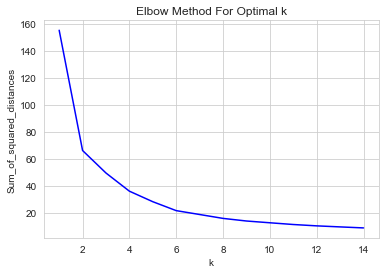

array([ 6, 10,  8, ..., 13,  1,  1], dtype=int32)

In [79]:
# Run Elbow to find the best K
elbow_plot(principalComponents,maxK=15)

Apparently, K=3 is the best one since the steepest slope is at 3.

In [80]:
def kmean_closed_planet(df_num,df_pca):

    num_clusters=df_num.shape[0] // 2

    while num_clusters>2:
        clf = KMeans(n_clusters=num_clusters, 
                    max_iter=100, 
                    init='k-means++', 
                    n_init=1)
        clf.fit_predict(df_num)
        cluster_assignment = clf.labels_

        num_clusters=num_clusters-1
        cdf=pd.DataFrame(columns=["cluster_id","planet"])

        for i in range(len(cluster_assignment)):
            new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                        "planet":df_pca.iloc[i]['planet']

                                }
                                    )
            cdf=pd.concat([cdf,pd.DataFrame(new_row).T],axis=0,ignore_index=True)
            #cdf=cdf.append(new_row,ignore_index=True)

        cdf.head()
        df_k=pd.merge(df_pca, cdf, how='inner')
        # If one cluster includes both cat=='no' and cat!='no', that means certain planets are closed to habitable one
        df_closed=pd.DataFrame(columns=df_k.columns)
        for cluster_id in df_k.cluster_id.unique():
            if (len(df_k[df_k.cluster_id==cluster_id].cat.unique())>1) and \
            ('no' in df_k[df_k.cluster_id==cluster_id].cat.unique()):
                df_closed=pd.concat([df_closed,df_k[df_k.cluster_id==cluster_id]],axis=0,ignore_index=True)
        #df_closed=df_k[df_k.cluster_id.isin(df_k[df_k['cat']!='no'].cluster_id)]
        if df_closed.empty==False:
            return df_closed
        else:
            continue
    return none


In [81]:
df_k_closed=kmean_closed_planet(df_num,df_pca)

In [82]:
df_k_closed.head()

,principal component 1,principal component 2,planet,cat,cluster_id
0,-0.646158,0.785401,Kepler-1661 b,no,195
1,-0.735275,0.710277,Kepler-62 f,Conservative,195


Visualizing the clustering

In [83]:
import altair as alt
alt.Chart(df_k_closed).mark_point(size=60,filled=True,stroke='black').encode(
    x='principal component 1',
    y='principal component 2',
    color=alt.Color('cluster_id:N',scale=alt.Scale(range=['green','yellow','red'])),
    shape=alt.Shape('cat:N'),
    tooltip=['cluster_id','cat','planet']
).properties(title='PCA & Kmeans',height=400,width=500).interactive()

alt.Chart(...)

The above chart shows which unhabitable planet(s) is closed to the habitable planets.
This could be the candidates for further verification to be converted to the habitable ones.

Let's change to another dimensionality reduction and clustering algorithm to look for more candidates.

##### 2.3 Using UMAP + DBSCAN to cluster the planets

In [84]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=2, 
                            metric='cosine').fit_transform(df_num)

Looking for the best cluster size

In [85]:
import hdbscan
from sklearn.metrics import silhouette_score,calinski_harabasz_score

# Create an instance of HDBSCAN with a specified min_cluster_size
clusters=range(2,100)
silhouette_scores = []

for size in clusters:
    cluster = hdbscan.HDBSCAN(min_cluster_size=size,
                              metric='euclidean',                      
                              cluster_selection_method='eom').fit(umap_embeddings)

    # Fit the clusterer to the data
    cluster.fit(umap_embeddings)

    # Calculate the Silhouette score for the clustering
    silhouette_avg = silhouette_score(umap_embeddings, cluster.labels_, metric='euclidean', random_state=42)
 
    
    # Print the Silhouette score
    silhouette_scores.append(silhouette_avg)
    #print("The Silhouette score is:", silhouette_avg)

# Create a Pandas DataFrame to store the Silhouette scores and cluster sizes
df = pd.DataFrame({'Cluster Size': clusters, 'Silhouette Score': silhouette_scores})

# Create a line chart using Altair
chart = alt.Chart(df).mark_line().encode(
    x='Cluster Size',
    y='Silhouette Score',
    tooltip=['Cluster Size','Silhouette Score']
).properties(title='Silhousette Scores',height=400,width=500)

# Display the chart
chart

alt.Chart(...)

In [86]:
# Find the cluster size with the highest Silhouette score
min_cluster_size=df.iloc[df['Silhouette Score'].argmax()]['Cluster Size'].astype(int)

In [105]:
df['Silhouette Score'].argsort()[::-1]

97    59
96    40
95    43
94    44
93    45
      ..
4     49
3     50
2     21
1     22
0      9
Name: Silhouette Score, Length: 98, dtype: int64

In [88]:
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=2, 
                            metric='cosine').fit_transform(df_num)

# Create an instance of HDBSCAN with a specified min_cluster_size=30
cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
        # Create the df to store the cluster labels
df_uh = pd.DataFrame(data = umap_embeddings
                    , columns = ['UMAP component 1', 'UMAP component 2'])

df_uh['planet']=df_name['PLANET']
df_uh['cat']=df_name['cat']
        
uh_cluster_assignment = cluster.labels_

uh_cdf=pd.DataFrame(columns=["cluster_id","planet"])

for i in range(len(uh_cluster_assignment)):
            new_row=pd.Series(data={"cluster_id":uh_cluster_assignment[i],
                                        "planet":df_pca.iloc[i]['planet']
                            

                           }
                            )
            uh_cdf=pd.concat([uh_cdf,pd.DataFrame(new_row).T],axis=0,ignore_index=True)
        
# Combine UMAP results with HDBSCAN results to see clustering
df_uh_c=df_uh.merge(uh_cdf,how='inner',on='planet')

# If one cluster includes both cat=='no' and cat!='no', that means certain planets are closed to habitable one
df_closed=pd.DataFrame(columns=df_uh_c.columns)


df_cnt=df_uh_c.groupby(['cluster_id','cat']).count().\
            reset_index()[['cluster_id','cat']].groupby('cluster_id').count().reset_index()
        

for cluster_id in df_cnt[df_cnt.cat>1].cluster_id.unique():
            if ('no' in df_uh_c[df_uh_c.cluster_id==cluster_id].cat.unique()):
                print(cluster_id)
                df_closed=pd.concat([df_closed,df_uh_c[df_uh_c.cluster_id==cluster_id]],axis=0,ignore_index=True)


-1


In [89]:
df_uh_c.groupby(['cluster_id','cat']).count().\
            reset_index()[['cluster_id','cat']].groupby('cluster_id').count().reset_index()

,cluster_id,cat
0,-1,3
1,0,1
2,1,1


In [90]:
df_uh_c

,UMAP component 1,UMAP component 2,planet,cat,cluster_id
0,1.609221,12.817327,55 Cnc e,no,1
1,5.730979,10.888522,BD+20 594 b,no,1
2,11.854760,8.968970,CFHTWIR-Oph 98 b,no,0
3,7.860921,6.857231,CoRoT-10 b,no,-1
4,9.782009,12.978155,CoRoT-11 b,no,0
...,...,...,...,...,...
998,8.759734,8.833702,XO-3 b,no,0
999,8.905252,12.798108,XO-4 b,no,0
1000,11.617813,12.050407,XO-5 b,no,0
1001,11.061763,11.030755,XO-6 b,no,0


In [91]:
def hdbscan_closed_planet(df_num,df_name):

    min_cluster_size=2
    umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=2, 
                            metric='cosine').fit_transform(df_num)

    while min_cluster_size>=2:
        # Create an instance of HDBSCAN with a specified min_cluster_size=30
        cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
        # Create the df to store the cluster labels
        df_uh = pd.DataFrame(data = umap_embeddings
                    , columns = ['UMAP component 1', 'UMAP component 2'])

        df_uh['planet']=df_name['PLANET']
        df_uh['cat']=df_name['cat']
        
        uh_cluster_assignment = cluster.labels_

        uh_cdf=pd.DataFrame(columns=["cluster_id","planet"])

        for i in range(len(uh_cluster_assignment)):
            new_row=pd.Series(data={"cluster_id":uh_cluster_assignment[i],
                                        "planet":df_pca.iloc[i]['planet']
                            

                           }
                            )
            uh_cdf=pd.concat([uh_cdf,pd.DataFrame(new_row).T],axis=0,ignore_index=True)
        
        # Combine UMAP results with HDBSCAN results to see clustering
        df_uh_c=df_uh.merge(uh_cdf,how='inner',on='planet')

        # If one cluster includes both cat=='no' and cat!='no', that means certain planets are closed to habitable one
        df_closed=pd.DataFrame(columns=df_uh_c.columns)

        # df_closed.groupby(['cluster_id','cat']).count()
        df_cnt=df_uh_c.groupby(['cluster_id','cat']).count().\
            reset_index()[['cluster_id','cat']].groupby('cluster_id').count().reset_index()
        
        #print(df_cnt.cluster_id.unique())
        for cluster_id in df_cnt[df_cnt.cat>1].cluster_id.unique():
            if ('no' in df_uh_c[df_uh_c.cluster_id==cluster_id].cat.unique()):
                # print(cluster_id)
                df_closed=pd.concat([df_closed,df_uh_c[df_uh_c.cluster_id==cluster_id]],axis=0,ignore_index=True)
        if df_closed.empty==False:
            cluster_size=min_cluster_size
            min_cluster_size=1
            return df_closed,cluster_size
        else:
            min_cluster_size+=1

        #print(min_cluster_size)
    return none,none

In [92]:
df_h_closed,cluster_size=hdbscan_closed_planet(df_num,df_name)

In [93]:
cluster_size

2

In [94]:
df_h_closed

,UMAP component 1,UMAP component 2,planet,cat,cluster_id
0,0.871747,10.552530,55 Cnc e,no,-1
1,9.300935,12.321654,CoRoT-11 b,no,-1
2,11.052808,9.598197,CoRoT-12 b,no,-1
3,7.344000,12.472969,CoRoT-17 b,no,-1
4,9.061550,10.547491,CoRoT-19 b,no,-1
...,...,...,...,...,...
178,8.208452,4.767089,Kepler-22 b,Optimistic,4
179,8.166416,4.679496,TOI-2285 b,no,4
180,8.206086,4.559357,Kepler-34 b,no,5
181,8.200433,4.522024,Kepler-62 e,Optimistic,5


In [95]:
alt.Chart(df_h_closed).mark_point(size=60).encode(
    x='UMAP component 1',
    y='UMAP component 2',
    color=alt.Color('cluster_id', scale=alt.Scale(scheme='category20c')),
    shape=alt.Shape('cat:N'),
    tooltip=['planet']
).properties(title='UMAP & HBDSCAN',height=400,width=500).interactive()

alt.Chart(...)

The above HDBSCAN result still could not identify which candidates are more closed to habitable planets.
Thus, we will take cosine similarity to precisely look for those candidates.

##### 2.4 Look for similiar planets by COSINE SIMILARITY

In [96]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Find the similiar sentences based on the similarity level
# return the similar sentences in the same list with 
def similarity_clustering(df_full,simlevel=0.9):
  if df_full.empty:
    print('Please assign list!')
    return pd.DataFrame()
  else:
    df_num = pd.DataFrame(df_full[df_full.select_dtypes(include=['int', 'float']).columns])
    df_name = pd.DataFrame(df_full[['PLANET','cat']])
    
    # Set the simlarity threshold 
    THRESHOLD=simlevel

    #Create dateset to cluster the similar planets
    new_cluster=pd.DataFrame(columns=list(df_name.columns)+['score','id','cluster','s_planet','s_cat'])

    for i in range(len(df_name)):
        if df_name.iloc[i]['cat']!='no':
            continue
        else:
            df_temp=pd.DataFrame(columns=df_name.columns)
            str_to_predict=df_num.iloc[i]
            # Compare similarity
            sim=cosine_similarity([str_to_predict],df_num)
            j=np.argmax(sim)
            sim_rows=list(np.where((sim[0]>THRESHOLD)))[0]
            # cluster the sentences in training set by error records
            rest_rows=list(set(sim_rows)-set(new_cluster.id.to_list()))
            if rest_rows !=[]:
                if new_cluster.empty:
                    cluster_id=0
                else:
                    cluster_id=new_cluster['cluster'].max()+1       
                df_temp=df_name.iloc[rest_rows]
                if df_temp.empty== False:
                    df_temp['score']=sim[0][rest_rows]
                    df_temp['id']=rest_rows
                    df_temp['cluster']=cluster_id
                    df_temp['s_planet']=df_name.iloc[i]['PLANET']
                    df_temp['s_cat']=df_name.iloc[i]['cat']
                    new_cluster=pd.concat([new_cluster,df_temp],axis=0,ignore_index=True)
                    #new_cluster=new_cluster.append(df_temp,ignore_index=True)

    return new_cluster

In [97]:
# Look for the similiar products which could be almost same
new_cluster=similarity_clustering(normalized_hz_cat,simlevel=0.9)

In [98]:
df_sim_cluster=new_cluster[new_cluster['cat']!=new_cluster['s_cat']].sort_values(by=['s_planet','score'],ascending=False)
df_sim_cluster

,PLANET,cat,score,id,cluster,s_planet,s_cat
1000,Kepler-22 b,Optimistic,0.905559,437,25,Kepler-1708 b,no
999,K2-18 b,Optimistic,0.943416,285,24,Kepler-1661 b,no
991,Kepler-62 f,Conservative,0.936500,531,22,Kepler-1647 b,no
987,LHS 1140 b,Optimistic,0.926039,583,22,Kepler-1647 b,no
988,LP 890-9 c,Conservative,0.922511,591,22,Kepler-1647 b,no
994,TRAPPIST-1 g,Conservative,0.919718,827,22,Kepler-1647 b,no
995,TRAPPIST-1 f,Conservative,0.918982,826,22,Kepler-1647 b,no
992,TRAPPIST-1 e,Conservative,0.917883,825,22,Kepler-1647 b,no
985,Kepler-62 e,Optimistic,0.956384,530,21,K2-3 d,no
983,TRAPPIST-1 d,Conservative,0.946937,824,21,K2-3 d,no


In [99]:
# Look for the cluster id in the kmeans
df_sim_k=pd.merge(df_sim_cluster,df_k[['planet','cluster_id']],how='inner',left_on='PLANET',right_on='planet')
df_sim_k=pd.merge(df_sim_k,df_k[['planet','cluster_id']],how='inner',left_on='s_planet',right_on='planet')
df_sim_k=df_sim_k[['PLANET','cat','s_planet','s_cat','score','cluster','cluster_id_x','cluster_id_y']]
df_sim_k.columns=['planet','cat','s_planet','s_cat','score','c_cluster','k_cluster_x','k_cluster_y']
df_sim_k

NameError: name 'df_k' is not defined

In [ ]:
# Look for the cluster id in the hdbscan
df_sim_kh=pd.merge(df_sim_k,df_uh_c[['planet','cluster_id']],how='inner',left_on='planet',right_on='planet')
df_sim_kh=pd.merge(df_sim_kh,df_uh_c[['planet','cluster_id']],how='inner',left_on='s_planet',right_on='planet')
df_sim_kh=df_sim_kh[['s_planet','s_cat','planet_x','cat','score','c_cluster','k_cluster_x','k_cluster_y','cluster_id_x','cluster_id_y']]
df_sim_kh.rename(columns={'planet_x':'planet'},inplace=True)
df_sim_kh

In [ ]:
sim_p_list=new_cluster[new_cluster['cat']!=new_cluster['s_cat']]['PLANET'].unique().tolist()+new_cluster[new_cluster['cat']!=new_cluster['s_cat']]['s_planet'].unique().tolist()
sim_p_list

The above list is the features of those planets are very similar, that means, it could be possible to
detect more habitable planets. 

We can visualize those planets by PCA and UMAP.

In [ ]:
import altair as alt

alt.Chart(df_k[df_k['planet'].isin(sim_p_list)]).mark_point(size=60,filled=True,stroke='black').encode(
    x='principal component 1',
    y='principal component 2',
    color=alt.Color('cat:N',scale=alt.Scale(range=['green','yellow','red'])),
    shape=alt.Shape('cluster_id:N'),
    tooltip=['cluster_id','cat','planet']
).properties(title='PCA & Kmeans',height=400,width=500).interactive()

In [ ]:
alt.Chart(df_uh_c[df_uh_c['planet'].isin(sim_p_list)]).mark_point(size=60,filled=True,stroke='black').encode(
    x='UMAP component 1',
    y='UMAP component 2',
    color=alt.Color('cat:N',scale=alt.Scale(range=['green','yellow','red'])),
    shape=alt.Shape('cluster_id:N'),
    tooltip=['planet','cat','cluster_id']
).properties(title='UMAP & HBDSCAN',height=400,width=500).interactive()

In [ ]:
count_null(normalized_hz_cat[normalized_hz_cat['PLANET'].isin(sim_p_list)])


Check the raidus and mass of planets since those are missing in the previous similarity check

In [ ]:
exoplanets.columns

In [ ]:
exoplanets[exoplanets['pl_name'].isin(sim_p_list)][['pl_masse']].head()

It looks like the data in NASA also has only one value in MASS. Thus, we have to find another way to
figure out mass and raidus.

In [ ]:
df_sim=hz[hz['PLANET'].isin(sim_p_list)]

In [ ]:
planets_ma_ra=df_sim[(df_sim['MASS']!='') & (df_sim['RADIUS']!='')]['PLANET'].unique()

In [ ]:
planets_ma_ra

In [ ]:
df_sim_cluster[df_sim_cluster['s_planet'].isin(planets_ma_ra)]

In [ ]:
hz_nona[hz_nona['PLANET'].isin(['Kepler-22 b','Kepler-1654 b'])]

In [ ]:
normalized_hz_cat[normalized_hz_cat['PLANET'].isin(['Kepler-22 b','Kepler-1654 b'])]


In [ ]:
ls_splanet=df_sim_cluster[df_sim_cluster['s_planet'].isin(planets_ma_ra)]['s_planet'].unique()
hz_nona[hz_nona['PLANET'].isin(ls_splanet)]

In [ ]:
hz_cat[hz_cat.cat=='Conservative'][set(hz_cat.columns) - set(['PLANET','Planet','cat'])]

In [ ]:
hz_cat[hz_cat.cat=='Optimistic'][set(hz_cat.columns) - set(['PLANET','Planet','cat'])]

#### Extract the weights from logisticRegression
Given the cosine similarity result could indicate the inhabitable exoplanets similar with habiable ones are habitable, it 
may come from being lack of weights of the feature, we need to consider to assign the weight to features.

One way to work out the weights is, to use the logistic regression to find out the weights, then multiply with features,
and take the cosine similarity to look for the similarity, which could help to improve the accuracy.

In [ ]:
#### Select randomly 40 inhabitable planets from the dataset

In [ ]:
normalized_hz_cat[normalized_hz_cat['cat']!='no'].shape

In [ ]:
# randomly select 20 planets from the dataset and combine with the 10 planets which are habitable
df_wset=pd.concat([normalized_hz_cat[normalized_hz_cat['cat']!='no'],
                   normalized_hz_cat[normalized_hz_cat['cat']=='no'].sample(800)])

# Replace 'cat' in the following: 0 - inhabitable, 1 - conservative, 2 - optimistic
df_wset['cat']=df_wset['cat'].replace({'no':0,'Conservative':1,'Optimistic':1})

In [ ]:
# Train the logistic regression model
from sklearn.linear_model import LogisticRegression

# Split the dataset into train and test
X_train= df_wset[list(set(df_wset.columns) - set(['PLANET','Planet','cat']))]
y_train= df_wset['cat']

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Extract weights from logistic regression
clf.coef_



In [ ]:
import numpy as np
# Multiply the weights with the normalized values
df_weights=np.multiply(clf.coef_,normalized_hz_cat[list(set(df_wset.columns) - set(['PLANET','Planet','cat']))])
# merge the weights with the planet names and categories
df_weighted_hz=pd.concat([df_weights,normalized_hz_cat[['PLANET','Planet','cat']]],axis=1,ignore_index=True)

In [ ]:
# Look for the similiar products which could be almost same
df_weighted_hz.columns=normalized_hz_cat.columns
new_weighted_cluster=similarity_clustering(df_weighted_hz,simlevel=0.9)

In [ ]:
df_weighted_sim_cluster=new_weighted_cluster[new_weighted_cluster['cat']!= \
                                             new_weighted_cluster['s_cat']].sort_values(by=['s_planet','score'],\
                                                                                        ascending=False)
df_weighted_sim_cluster

In [ ]:
hz_nona[hz_nona['PLANET'].isin(['Kepler-1647 b','GJ 414 A b'])]